# An introduction to I-24 MOTION trajectory data

## Useful links
- I24 MOTION website: https://i24motion.org/
- Request for data access: https://i24motion.org/data
- Data documentation: https://github.com/I24-MOTION/I24M_documentation
- Improvement tracker: https://github.com/I24-MOTION/I24M_improvement_tracker

## This tutorial will cover:
- Load JSON file using iterative JSON parser
- Trajectory data schema
- Compute derivative quantities (e.g., speed)
- Visualize a trajectory
- Plot a time-space diagram

## Import packages

In [1]:
import ijson
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from decimal import Decimal

### Read a JSON file using an iterative JSON parser

In [5]:
input_filename = "INCEPTION.22-11-22.tutorial.json"
file_path = os.path.join("../data_demo/", input_filename)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:
        if record["direction"] == -1 and (record["last_timestamp"]-record["first_timestamp"]>10):
            print("Found a trajectory example")
            break

Found a trajectory example


In [ ]:
for key, val in record.items():
    print(f"{key}: {val}")

### Convert from Decimal to float

In [7]:
class DecimalToFloatConverter:
    @staticmethod
    def convert_dict(dec_dict):
        if not isinstance(dec_dict, dict):
            raise ValueError("Input must be a dictionary")

        float_dict = {}
        for key, value in dec_dict.items():
            if isinstance(value, list):
                try:
                    float_dict[key] = np.array(value, dtype="float")
                except:
                    pass
            elif isinstance(value, Decimal):
                float_dict[key] = float(value)
            else:
                float_dict[key] = value
        
        return float_dict
    
converter = DecimalToFloatConverter()
record = converter.convert_dict(record)
print(record["x_position"][:10])

[314836.965897   314834.73954551 314832.51181865 314830.28271517
 314828.05223265 314825.82036756 314823.58711534 314821.35247048
 314819.11642661 314816.8789766 ]


### Compute the derivative quantities

In [8]:
speed = np.diff(record["x_position"])/np.diff(record["timestamp"])*record["direction"]
speed = np.append(speed[0], speed) 
speed[:10]*0.681818

array([37.94919921, 37.94919921, 37.97264308, 37.99610812, 38.01938789,
       38.04318107, 38.06682535, 38.09056353, 38.11441029, 38.13837878])

In [9]:
accel = np.diff(record["x_position"], n=2)/(np.diff(record["timestamp"][:-1])**2)*record["direction"]
accel[:10]

array([0.85960954, 0.86038588, 0.86190183, 0.86409837, 0.86695798,
       0.87040104, 0.87438231, 0.87884546, 0.88375831, 0.88907717])

### Visualize a trajectory

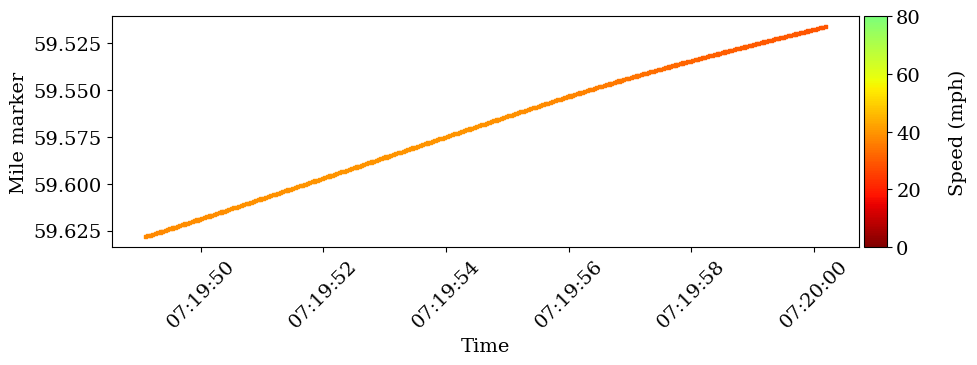

In [10]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,marker = 's',s=5)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()


### Plot a time-space diagram (6:00-6:10 AM, Westbound)

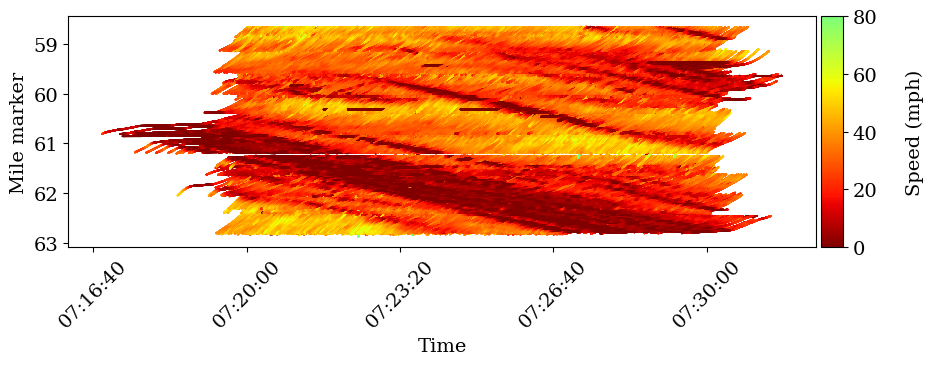

In [11]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:  
        if record["direction"] == -1:
            record = converter.convert_dict(record)
            speed = np.diff(record["x_position"])/np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)   
            im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= -speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,s=0.1)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()

### Plot a time-space diagram (8:00-8:10 AM, Westbound)

In order to plot these additional data, you will need to download the appropriate file from i24motion.org/data using your account credentials. Download it to the same directory where you found `INCEPTION.22-11-22.tutorial.json`, or else change the path location below.

In [ ]:
input_filename = "data_12.json"
file_path = os.path.join("../data_demo/", input_filename)

# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:  
        if record["direction"] == -1:
            record = converter.convert_dict(record)
            speed = np.diff(record["x_position"])/np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)   
            im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= -speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,s=0.1)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()